Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 128MB/s]


🔄 Loaded checkpoint from epoch 14
Epoch [15/30] - Train Loss: 0.0828, Train Acc: 0.9786, Test Acc: 0.9100
Epoch [16/30] - Train Loss: 0.0623, Train Acc: 0.9857, Test Acc: 0.9600
Epoch [17/30] - Train Loss: 0.0349, Train Acc: 0.9940, Test Acc: 0.9600
Epoch [18/30] - Train Loss: 0.0339, Train Acc: 0.9929, Test Acc: 0.9850
Epoch [19/30] - Train Loss: 0.0310, Train Acc: 0.9940, Test Acc: 0.9700
Epoch [20/30] - Train Loss: 0.0270, Train Acc: 0.9964, Test Acc: 0.9600
Epoch [21/30] - Train Loss: 0.0478, Train Acc: 0.9917, Test Acc: 0.9650
Epoch [22/30] - Train Loss: 0.0665, Train Acc: 0.9881, Test Acc: 0.9550
Epoch [23/30] - Train Loss: 0.0617, Train Acc: 0.9881, Test Acc: 0.9600
⛔ Early stopping triggered


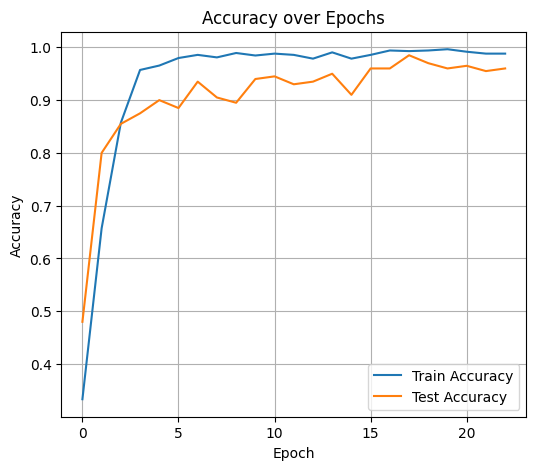

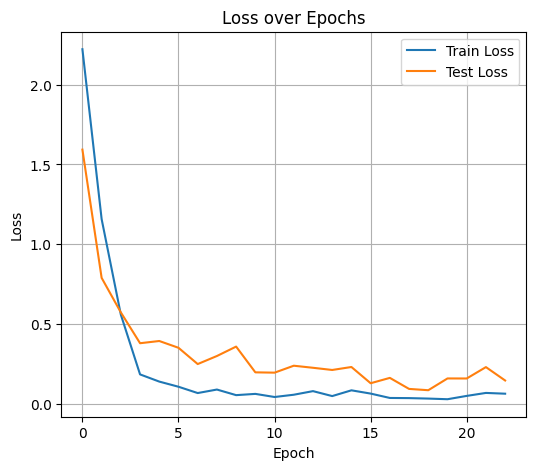

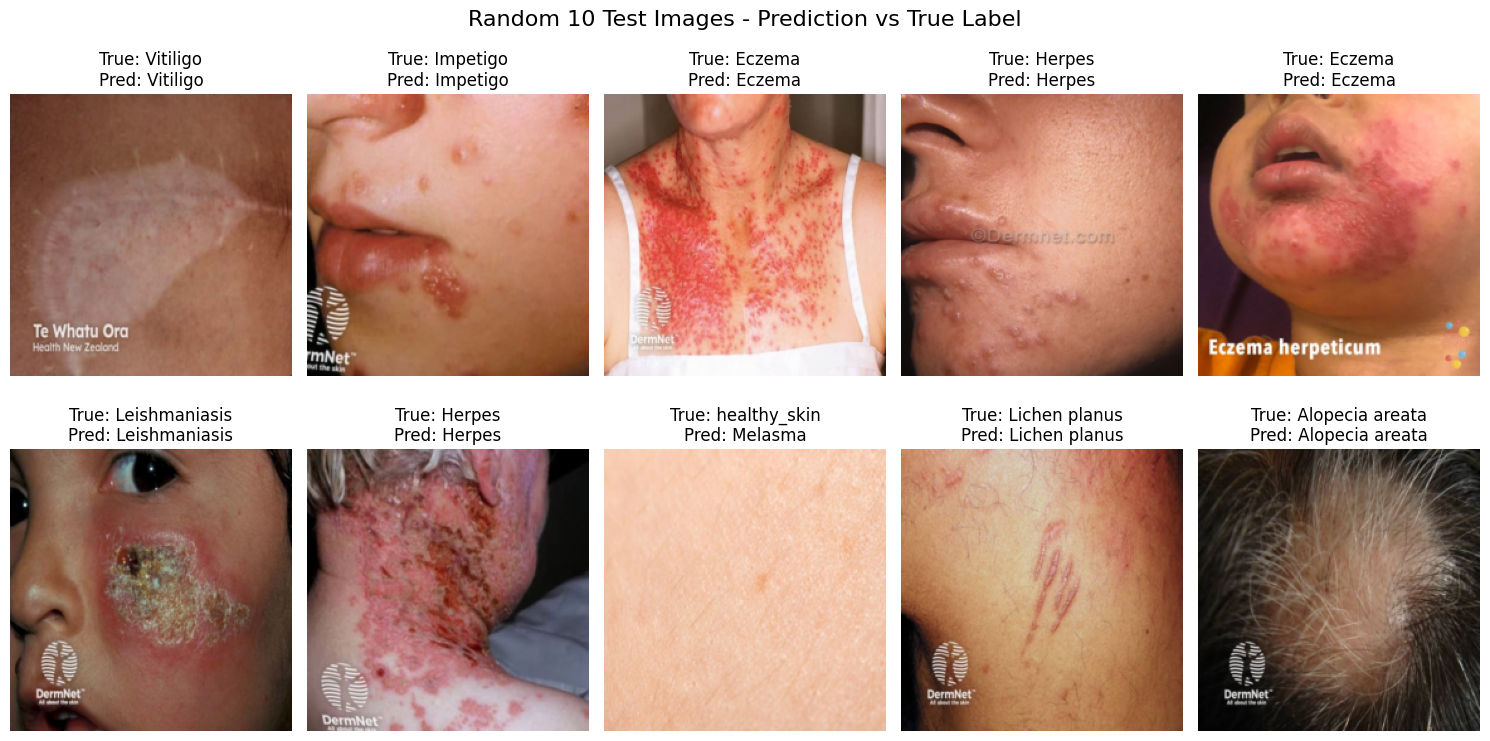

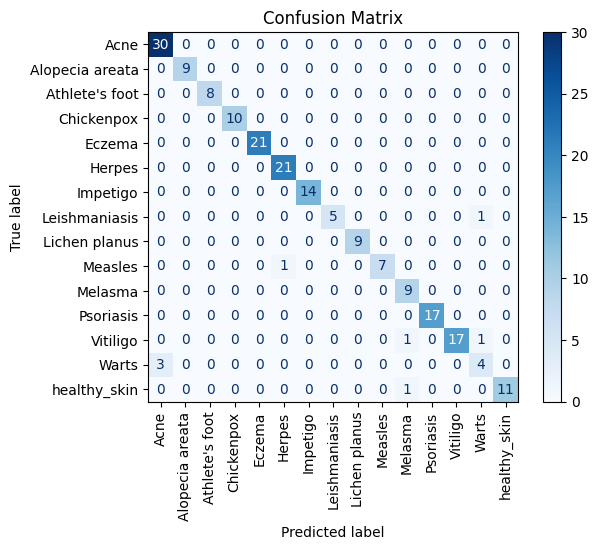

In [ ]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== Data Preparation ====================
TRAIN_CSV = '/content/drive/MyDrive/skindata/train.csv'
TEST_CSV = '/content/drive/MyDrive/skindata/test.csv'
CHECKPOINT_PATH = '/content/drive/MyDrive/skindata/checkpoint.pth'

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

image_column = train_df.columns[0]
class_column = train_df.columns[-1]
symptom_columns = train_df.columns[1:-1]

classes = sorted(train_df[class_column].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def gdrive_to_direct_link(url):
    file_id = url.split('/d/')[1].split('/')[0]
    return f'https://drive.google.com/uc?export=download&id={file_id}'

class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_url = gdrive_to_direct_link(row[image_column])
        label = class_to_idx[row[class_column]]
        symptoms = row[symptom_columns].values.astype('float32')

        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224))

        return image, torch.tensor(symptoms), label

train_dataset = SkinDataset(train_df, transform=train_transform)
test_dataset = SkinDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==================== Model ====================
class SkinClassifier(nn.Module):
    def __init__(self, symptom_dim, num_classes):
        super().__init__()
        weights = EfficientNet_B3_Weights.DEFAULT
        self.cnn = efficientnet_b3(weights=weights)
        self.cnn.classifier = nn.Identity()
        self.symptom_fc = nn.Sequential(
            nn.Linear(symptom_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(1536 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, symptoms):
        img_feat = self.cnn(image)
        sym_feat = self.symptom_fc(symptoms)
        combined = torch.cat([img_feat, sym_feat], dim=1)
        out = self.fc(combined)
        return out

model = SkinClassifier(symptom_dim=len(symptom_columns), num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

# ==================== Load Checkpoint If Exists ====================
start_epoch = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_acc = 0

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    best_acc = checkpoint['best_acc']
    print(f"🔄 Loaded checkpoint from epoch {start_epoch}")
else:
    print("🚀 Starting training from scratch")

# ==================== Training ====================
patience, counter = 5, 0
num_epochs = 30

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for images, symptoms, labels in train_loader:
        images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
        outputs = model(images, symptoms)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    running_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, symptoms, labels in test_loader:
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            outputs = model(images, symptoms)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'best_acc': best_acc
    }, CHECKPOINT_PATH)

    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered")
            break

# ==================== Plotting Accuracy ====================
plt.figure(figsize=(6, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ==================== Plotting Loss ====================
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ==================== Show Predictions ====================
model.eval()
all_images, all_symptoms, all_labels_tensor = [], [], []
for images, symptoms, labels in test_loader:
    all_images.append(images)
    all_symptoms.append(symptoms)
    all_labels_tensor.append(labels)

all_images = torch.cat(all_images)
all_symptoms = torch.cat(all_symptoms)
all_labels_tensor = torch.cat(all_labels_tensor)

torch.manual_seed(torch.randint(0, 10000, (1,)).item())
indices = torch.randperm(len(all_images))[:10]
images = all_images[indices].to(device)
symptoms = all_symptoms[indices].to(device)
labels = all_labels_tensor[indices]

outputs = model(images, symptoms)
preds = outputs.argmax(dim=1)

plt.figure(figsize=(15, 8))
for i in range(10):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {idx_to_class[labels[i].item()]}\nPred: {idx_to_class[preds[i].item()]}")

plt.suptitle("Random 10 Test Images - Prediction vs True Label", fontsize=16)
plt.tight_layout()
plt.show()

# ==================== Confusion Matrix ====================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/skindata/skin_model.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /content/drive/MyDrive/skindata/skin_model.pth


In [ ]:
example_input_image = torch.randn(1, 3, 224, 224).to(device)
example_input_symptoms = torch.randn(1, len(symptom_columns)).to(device)

traced_model = torch.jit.trace(model, (example_input_image, example_input_symptoms))
torchscript_path = '/content/drive/MyDrive/skindata/skin_model_scripted.pt'
traced_model.save(torchscript_path)

Mounted at /content/drive


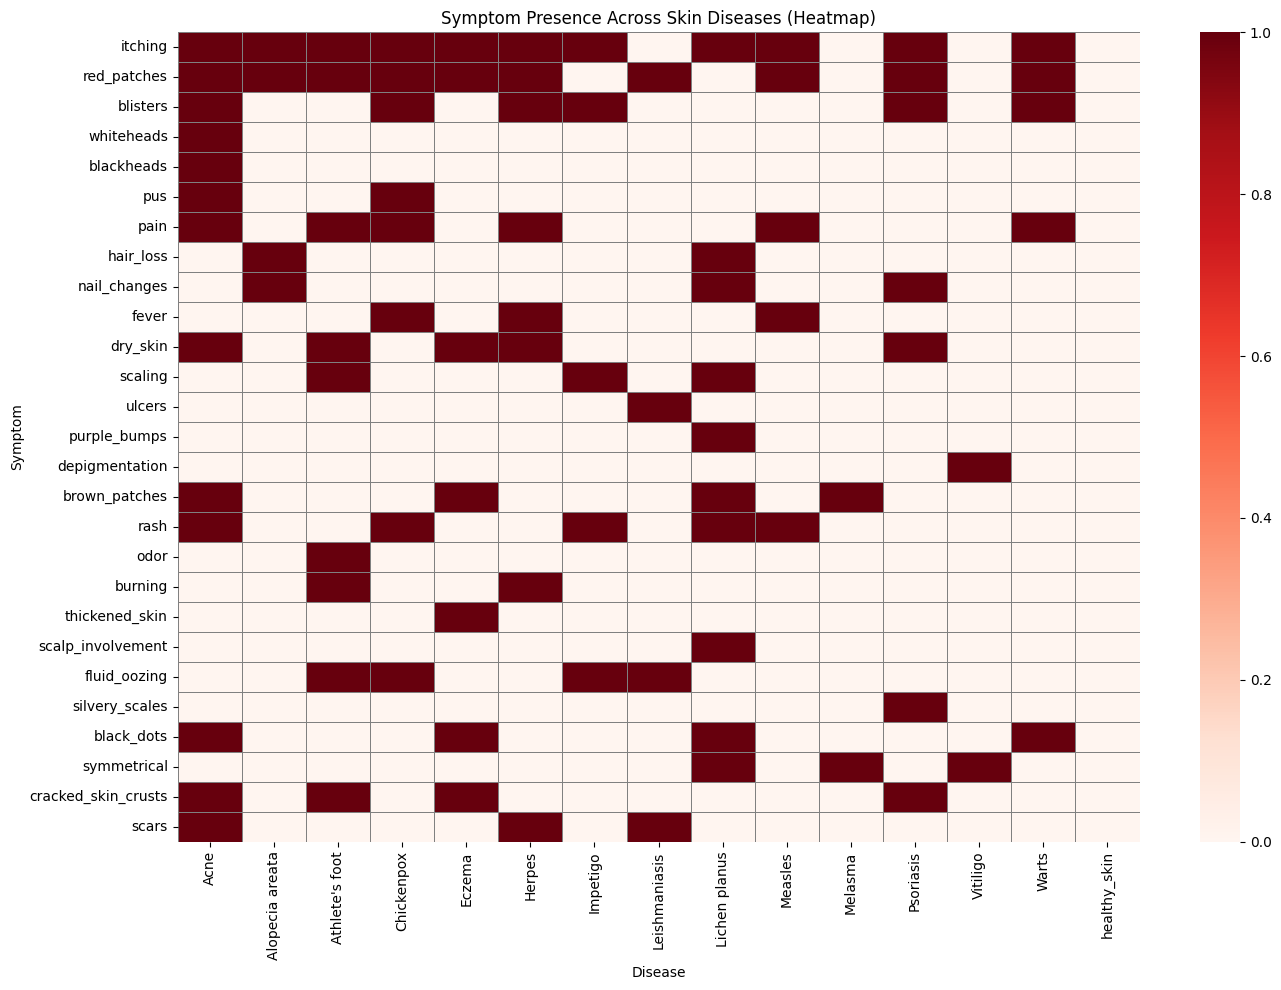

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/skindata/train.csv'
df = pd.read_csv(file_path)

symptom_cols = df.columns[1:-1]
disease_col = 'class'
import seaborn as sns

heatmap_data = df.groupby(disease_col)[symptom_cols].max().T

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, linecolor='gray')
plt.title("Symptom Presence Across Skin Diseases (Heatmap)")
plt.xlabel("Disease")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


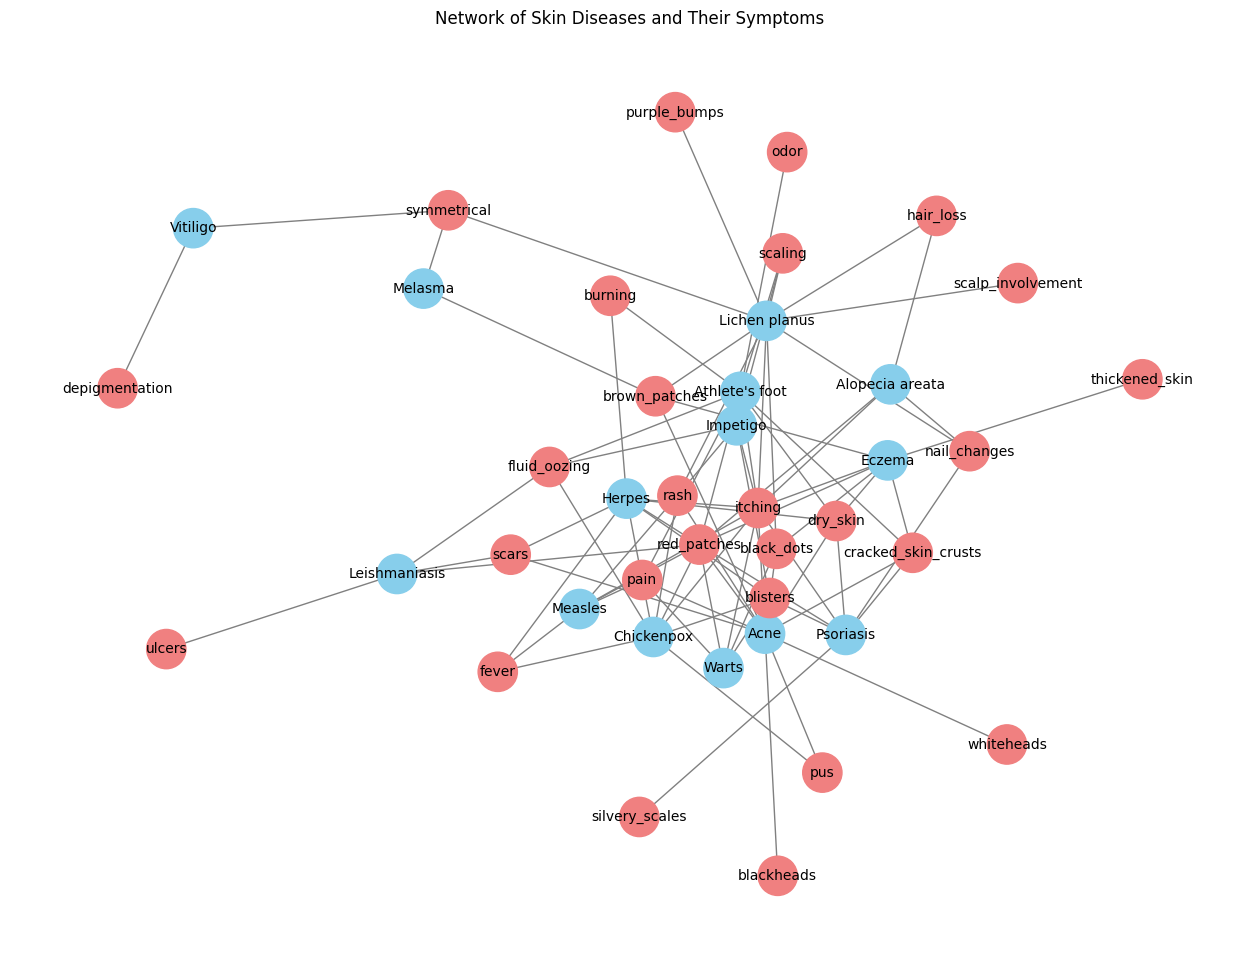

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/skindata/train.csv'
df = pd.read_csv(file_path)

symptom_cols = df.columns[1:-1]
disease_col = 'class'

G = nx.Graph()
for _, row in df.iterrows():
    for symptom in symptom_cols:
        if row[symptom] == 1:
            G.add_edge(row[disease_col], symptom)

node_colors = []
for node in G.nodes():
    if node in df[disease_col].unique():
        node_colors.append('skyblue')
    else:
        node_colors.append('lightcoral')

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx(G, pos, with_labels=True, node_size=800, node_color=node_colors,
                 font_size=10, edge_color='gray')
plt.title("Network of Skin Diseases and Their Symptoms")
plt.axis('off')
plt.show()
